# Recipe Clustering V2 – Analysis Notebook

Clusters **30 strawberry-aroma recipes** (Versuchsdaten_2.csv) using three methods.

### What's new vs V1
| Step | Change |
|------|--------|
| **Preprocessing** | Identified solvents/carriers (ignone_substances.csv) are zeroed out; remaining Totalmenge re-normalised to aliquots (sum = 1 per recipe) |
| **Feature columns** | Sensorik_1–4 + Odour Type 1–3 (FlavourWheel) – both with descending positional weights |
| **Ingredient weight** | `positional_weight × Totalmenge × (1 / Threshold)` captures quantity **and** odour potency |
| **Clustering** | Same 3 methods: HDBSCAN · Agglomerative · FAISS |

### How `positional_weight` works

The formula is the same for both column groups — only `n_cols` changes:

```
pos_weight(position, n_cols) = (n_cols + 1 - position) / n_cols
```

| Column group | n_cols | pos 1 | pos 2 | pos 3 | pos 4 |
|---|---|---|---|---|---|
| Sensorik_1–4 | 4 | 1.00 | 0.75 | 0.50 | 0.25 |
| Odour Type 1–3 | 3 | 1.00 | 0.67 | 0.33 | — |

The total contribution of a term from a single ingredient to its vector dimension is:

```
final contribution = pos_weight_sensorik × Totalmenge × (1/Threshold)   [if term appears in Sensorik]
                   + pos_weight_odour    × Totalmenge × (1/Threshold)   [if term appears in Odour Type]
```

Which simplifies to:

```
= (pos_weight_sensorik + pos_weight_odour) × Totalmenge × (1/Threshold)
```

> **Shared vocabulary:** Sensorik and Odour Type terms map into the **same feature dimensions**. If the same term (e.g. `"fruity"`) appears in both column groups for the same ingredient, both positional weights are **summed** — so overlap reinforces that term's importance. If it only appears in one group, only that group's positional weight applies.


## Setup

In [1]:
# Uncomment to install if needed
# !pip install pandas numpy scikit-learn hdbscan faiss-cpu matplotlib


In [2]:
import sys, os
# Add project root to path so we can import the v2 module
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

import hdbscan
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

try:
    import faiss
    FAISS_AVAILABLE = True
    print("FAISS available")
except ImportError:
    FAISS_AVAILABLE = False
    print("FAISS not available – Method 3 will be skipped")

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
print("Libraries loaded successfully")


FAISS available
Libraries loaded successfully


---
## 1. Load Data & Preprocessing

### 1a. Load raw Versuchsdaten_2.csv

In [3]:
DATA_PATH   = '../data/gold/Versuchsdaten_2.csv'
IGNORE_PATH = '../data/gold/ignone_substances.csv'
CAS_PATH    = '../data/gold/CAS Nummern.csv'
OUTPUT_DIR  = '../outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_raw = pd.read_csv(DATA_PATH)
ign    = pd.read_csv(IGNORE_PATH)
# Header starts at row 14 (0-indexed row 13)
cas    = pd.read_csv(CAS_PATH, header=13)

print(f"Versuchsdaten_2  : {df_raw.shape[0]} rows, {df_raw['Rez.-Nr.'].nunique()} recipes")
print(f"Ignore substances: {len(ign)} entries")
print(f"CAS lookup table : {len(cas)} entries, columns: {cas.columns.tolist()}")


Versuchsdaten_2  : 836 rows, 30 recipes
Ignore substances: 9 entries
CAS lookup table : 1341 entries, columns: ['Stamm-Nr.', 'Stammbezeichnung', 'Ident.', 'Vers.', 'Int. Id.', 'Partner', 'CAS-Nr.: - Hinweis 1', 'Unnamed: 7']


In [4]:
df_raw.head(3)


,Stamm-Nr.,Rez.-Nr.,Rezepturbezeichnung,ERP-Nr.,Name,Totalmenge,CAS-Nr.: - Hinweis 1,Sensorik_1,Sensorik_2,Sensorik_3,Sensorik_4,Odour Type 1 FlavourWheel,Odour Type 2 Flavour Wheel,Odour Type 3 Flavour Wheel,Threshold ppm (Datenbank),Unnamed: 15,Unnamed: 16,Unnamed: 17
0,29201964,187.893P,Erdbeer-Aroma,60030302,Phenethylalkohol Halal Kosher,0.000045,60-12-8,floral,rose,dried rose,NaN,floral,NaN,NaN,5,NaN,NaN,NaN
1,RE00956_A01,185.615,Erdbeer-Aroma,60030309,Propionsäure Kosher Halal,0.009602,79-09-4,pungent,acidic,cheesy,vinegar,unpleasent,dairy,fruity,6.666666667,NaN,NaN,NaN
2,29200974,187.061P,Erdbeer-Aroma,60030309,Propionsäure Kosher Halal,0.000200,79-09-4,pungent,acidic,cheesy,vinegar,unpleasent,dairy,fruity,6.666666667,NaN,NaN,NaN


In [5]:
ign


,Ident,Name,Unnamed: 2
0,R01776,Propylenglycol Kosher Halal,NaN
1,R01356,Milchsäure 80%ig (als Aromastoff) Halal Kosher,NaN
2,R01420,MCT Öl palmölbasiert,NaN
3,R01655,Glycerin (palmölfrei) Halal,NaN
4,R01935,Triacetin Kosher Halal,NaN
5,R02119,Ethanol (unversteuert) IP Kosher,NaN
6,R03370,Wasser,NaN
7,R04390,"Sonnenblumen-Öl Raffinat, Ölsäurereich V Halal",NaN
8,R07705,"Invertzuckersirup 72,7/67 (als Trägerstoff)",NaN


### 1b. Identify ignored substances via CAS number lookup

Matching chain:
```
ignone_substances.csv  →  (Ident)  →  CAS Nummern.csv  →  (CAS-Nr.)  →  Versuchsdaten_2.csv
```
1. Join `ignone_substances` (Ident) with `CAS Nummern` (Ident.) to get each substance's CAS number  
2. Zero out `Totalmenge` for any row in `Versuchsdaten_2` whose `CAS-Nr.: - Hinweis 1` matches

In [6]:
# Step 1: join ignore list with CAS lookup to get CAS numbers
ign_cas = ign[['Ident']].merge(
    cas[['Ident.', 'CAS-Nr.: - Hinweis 1']].rename(columns={'Ident.': 'Ident'}),
    on='Ident', how='left'
)
print("Ignore list with resolved CAS numbers:")
print(ign_cas.to_string(index=False))
print()

# Step 2: extract the valid CAS numbers (some substances may not be in the CAS file)
cas_to_ignore = set(ign_cas['CAS-Nr.: - Hinweis 1'].dropna().astype(str).str.strip())
print(f"CAS numbers resolved : {len(cas_to_ignore)}")
print(f"Entries without CAS  : {ign_cas['CAS-Nr.: - Hinweis 1'].isna().sum()} "
      f"({ign_cas.loc[ign_cas['CAS-Nr.: - Hinweis 1'].isna(), 'Ident'].tolist()})")
print()

# Step 3: zero out Totalmenge in Versuchsdaten_2 where CAS matches
df = df_raw.copy()
df['_cas'] = df['CAS-Nr.: - Hinweis 1'].astype(str).str.strip()
mask_ignored = df['_cas'].isin(cas_to_ignore)
n_zeroed = mask_ignored.sum()
df.loc[mask_ignored, 'Totalmenge'] = 0.0
df.drop(columns='_cas', inplace=True)

print(f"Ingredient rows zeroed: {n_zeroed}")
print()
print("Substances zeroed (unique):")
zeroed = df_raw.loc[mask_ignored, ['Name', 'CAS-Nr.: - Hinweis 1']].drop_duplicates()
print(zeroed.to_string(index=False))


Ignore list with resolved CAS numbers:
 Ident CAS-Nr.: - Hinweis 1
R01776              57-55-6
R01356              79-33-4
R01420           73398-61-5
R01655              56-81-5
R01935             102-76-1
R02119              64-17-5
R03370                  NaN
R04390            8001-21-6
R07705                  NaN

CAS numbers resolved : 7
Entries without CAS  : 2 (['R03370', 'R07705'])

Ingredient rows zeroed: 47

Substances zeroed (unique):
                                          Name CAS-Nr.: - Hinweis 1
                        Triacetin Kosher Halal             102-76-1
                   Propylenglycol Kosher Halal              57-55-6
              Ethanol (unversteuert) IP Kosher              64-17-5
Milchsäure 80%ig (als Aromastoff) Halal Kosher              79-33-4


### 1c. Re-normalise Totalmenge to aliquots (per recipe, sum = 1)

In [7]:
# Vectorised normalisation – avoids groupby.apply column-drop issue
per_recipe_total = df.groupby('Rez.-Nr.')['Totalmenge'].transform('sum')
df['Totalmenge'] = np.where(per_recipe_total > 0,
                            df['Totalmenge'] / per_recipe_total,
                            df['Totalmenge'])

# Verify
sums = df.groupby('Rez.-Nr.')['Totalmenge'].sum()
assert sums.round(6).eq(1.0).all(), "Not all recipes sum to 1!"

active_rows = (df['Totalmenge'] > 0).sum()
print(f"All recipe sums = 1.0  ✓")
print(f"Active ingredient rows (Totalmenge > 0): {active_rows} / {len(df)}")
print()
print("Active ingredients per recipe (range):",
      df[df['Totalmenge']>0].groupby('Rez.-Nr.').size().agg(['min','mean','max']).to_dict())

All recipe sums = 1.0  ✓
Active ingredient rows (Totalmenge > 0): 789 / 836

Active ingredients per recipe (range): {'min': 13.0, 'mean': 26.3, 'max': 47.0}


### 1d. Preprocessing effect visualisation

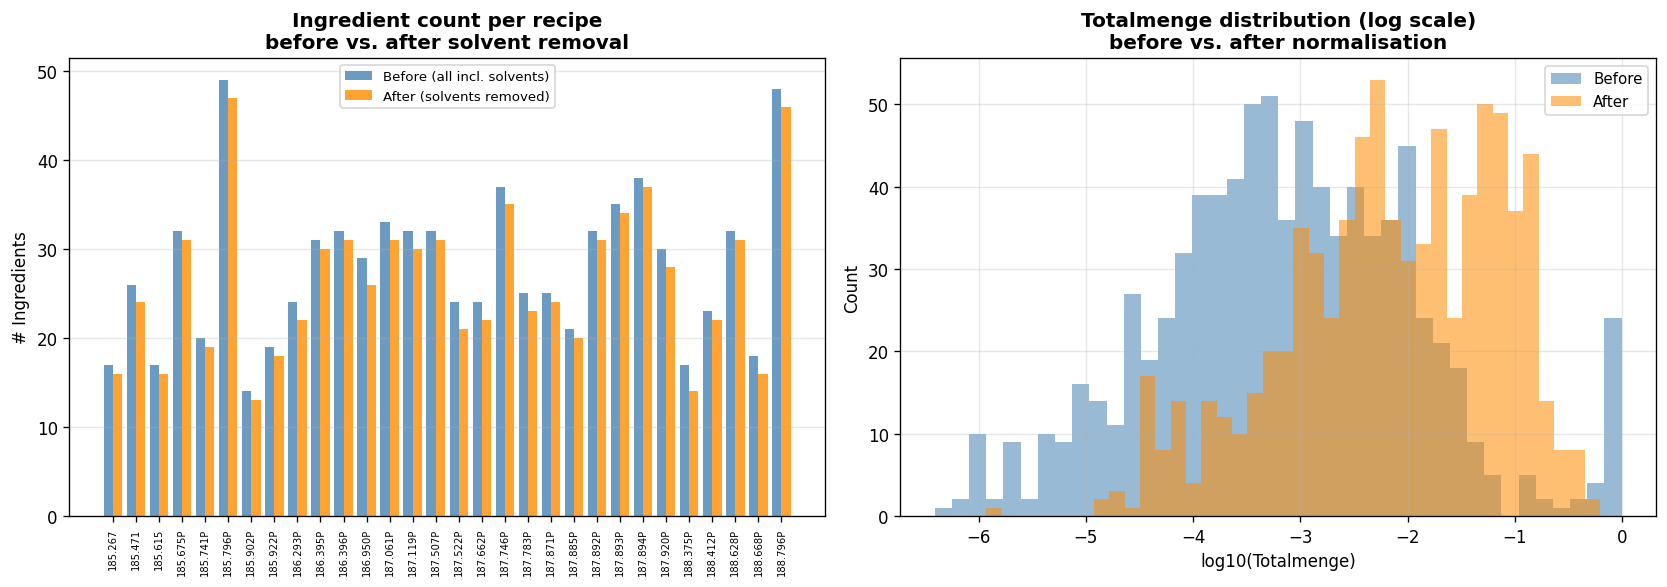

Saved → v2_preprocessing.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before/after ingredient counts per recipe
n_before = df_raw.groupby('Rez.-Nr.').size()
n_after  = df[df['Totalmenge'] > 0].groupby('Rez.-Nr.').size()

ax = axes[0]
x = np.arange(len(n_before))
ax.bar(x - 0.2, n_before.values, 0.4, label='Before (all incl. solvents)', color='steelblue', alpha=0.8)
ax.bar(x + 0.2, n_after.reindex(n_before.index).fillna(0).values, 0.4,
       label='After (solvents removed)', color='darkorange', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(n_before.index, rotation=90, fontsize=6)
ax.set_ylabel('# Ingredients')
ax.set_title('Ingredient count per recipe\nbefore vs. after solvent removal', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, axis='y', alpha=0.3)

# Totalmenge distribution (log scale) before/after
ax2 = axes[1]
tq_before = df_raw['Totalmenge'].values
tq_after  = df[df['Totalmenge']>0]['Totalmenge'].values
ax2.hist(np.log10(tq_before[tq_before>0]), bins=40, alpha=0.55, color='steelblue', label='Before')
ax2.hist(np.log10(tq_after),               bins=40, alpha=0.55, color='darkorange', label='After')
ax2.set_xlabel('log10(Totalmenge)')
ax2.set_ylabel('Count')
ax2.set_title('Totalmenge distribution (log scale)\nbefore vs. after normalisation', fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/v2_preprocessing.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved → v2_preprocessing.png")

---
## 2. Feature Extraction

### Weight scheme

| Column group | # cols | Formula | pos 1 | pos last |
|---|---|---|---|---|
| Sensorik_1–4 | 4 | `(5 - pos) / 4` | 1.00 | 0.25 |
| Odour Type 1–3 | 3 | `(4 - pos) / 3` | 1.00 | 0.33 |

**Combined ingredient weight** = `positional_weight × Totalmenge × (1 / Threshold)`

- `Totalmenge` = aliquot share of the ingredient  
- `1 / Threshold` = odour potency (lower detection threshold → higher impact)  
- NaN / zero thresholds use a neutral factor of 1.0


In [9]:
SENSORIK_COLS = ['Sensorik_1', 'Sensorik_2', 'Sensorik_3', 'Sensorik_4']
ODOUR_COLS    = ['Odour Type 1 FlavourWheel',
                 'Odour Type 2 Flavour Wheel',
                 'Odour Type 3 Flavour Wheel']

def pos_weight(position, n_cols):
    """Descending positional weight: pos 1 → 1.0, pos n_cols → 1/n_cols"""
    return (n_cols + 1 - position) / n_cols

def thresh_factor(threshold_ppm, fallback=1.0):
    """Odour potency: 1/threshold. NaN/non-positive → fallback."""
    try:
        t = float(threshold_ppm)
        return 1.0 / t if (not np.isnan(t) and t > 0) else fallback
    except (TypeError, ValueError):
        return fallback

def norm_term(term):
    if pd.isna(term) or not isinstance(term, str):
        return None
    t = term.lower().strip().replace('"','').replace("'",'').rstrip('.,;:')
    return t if len(t) >= 2 else None

print("Weight examples – Sensorik (4 cols):",
      {f'pos {p}': round(pos_weight(p, 4), 3) for p in range(1, 5)})
print("Weight examples – Odour Type (3 cols):",
      {f'pos {p}': round(pos_weight(p, 3), 3) for p in range(1, 4)})
print("Threshold factor examples (1/T):",
      {f'{t} ppm': round(thresh_factor(t), 4) for t in [0.1, 1, 10, 100]})


Weight examples – Sensorik (4 cols): {'pos 1': 1.0, 'pos 2': 0.75, 'pos 3': 0.5, 'pos 4': 0.25}
Weight examples – Odour Type (3 cols): {'pos 1': 1.0, 'pos 2': 0.667, 'pos 3': 0.333}
Threshold factor examples (1/T): {'0.1 ppm': 10.0, '1 ppm': 1.0, '10 ppm': 0.1, '100 ppm': 0.01}


In [10]:
# Build combined vocabulary
all_terms = set()
for col in SENSORIK_COLS + ODOUR_COLS:
    if col in df.columns:
        for t in df[col].dropna().map(norm_term):
            if t:
                all_terms.add(t)

vocabulary   = sorted(all_terms)
vocab_to_idx = {t: i for i, t in enumerate(vocabulary)}

print(f"Combined vocabulary: {len(vocabulary)} unique terms")
print("Sample terms:", vocabulary[:10])


Combined vocabulary: 161 unique terms
Sample terms: ['acetic', 'acidic', 'alcoholic', 'aldehydic', 'almond', 'amber', 'animal', 'apple', 'apricot', 'baked']


In [11]:
# Pre-compute threshold factors for all rows
thresh_factors = df['Threshold ppm (Datenbank)'].apply(thresh_factor).values

# Extract per-recipe vectors
recipes   = df['Rez.-Nr.'].unique().tolist()
n_recipes = len(recipes)
n_feat    = len(vocabulary)
vectors   = np.zeros((n_recipes, n_feat), dtype=np.float64)

for r_idx, recipe in enumerate(recipes):
    rows = df[df['Rez.-Nr.'] == recipe]
    for loc_i, (row_i, row) in enumerate(rows.iterrows()):
        qty = float(row['Totalmenge'])
        if qty <= 0:
            continue  # ignored substance – skip

        t_fac = thresh_factors[df.index.get_loc(row_i)]
        ingr_weight = qty * t_fac          # Totalmenge × (1/Threshold)

        # Sensorik columns
        for pos, col in enumerate(SENSORIK_COLS, 1):
            if col not in df.columns: continue
            term = norm_term(row.get(col))
            if term and term in vocab_to_idx:
                vectors[r_idx, vocab_to_idx[term]] += pos_weight(pos, 4) * ingr_weight

        # Odour Type columns
        for pos, col in enumerate(ODOUR_COLS, 1):
            if col not in df.columns: continue
            term = norm_term(row.get(col))
            if term and term in vocab_to_idx:
                vectors[r_idx, vocab_to_idx[term]] += pos_weight(pos, 3) * ingr_weight

# L2-normalise
recipe_vectors = normalize(vectors)

print(f"Recipe vectors shape: {recipe_vectors.shape}")
print(f"Non-zero dimensions per recipe: {(recipe_vectors > 0).sum(axis=1).mean():.1f} (avg)")


Recipe vectors shape: (30, 161)
Non-zero dimensions per recipe: 57.7 (avg)


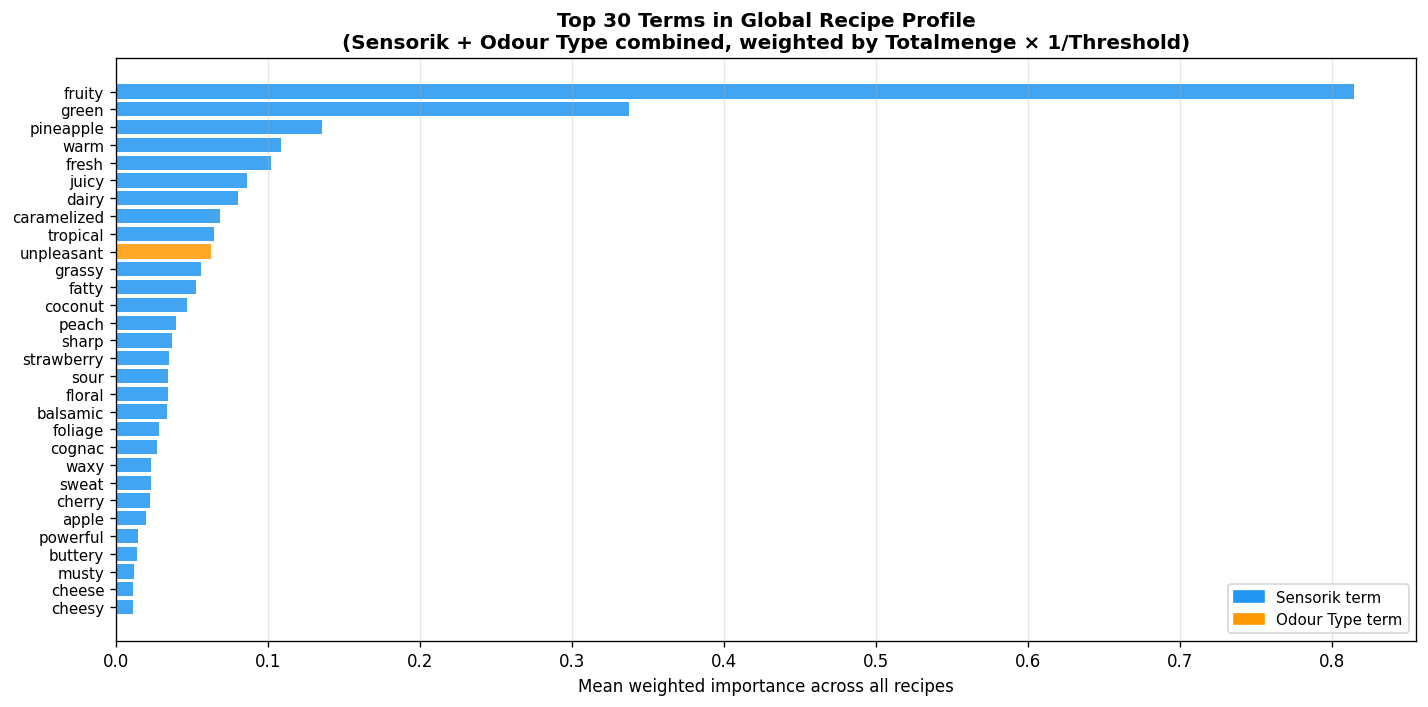

In [12]:
# Top contributing terms across all recipes
global_profile = recipe_vectors.mean(axis=0)
top30_idx = np.argsort(global_profile)[-30:][::-1]

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2196F3' if vocabulary[i] in [norm_term(v) for col in SENSORIK_COLS
           for v in df[col].dropna()] else '#FF9800' for i in top30_idx]
ax.barh(range(30), global_profile[top30_idx], color=colors[::-1] if False else colors, alpha=0.85)
ax.set_yticks(range(30))
ax.set_yticklabels([vocabulary[i] for i in top30_idx], fontsize=9)
ax.set_xlabel('Mean weighted importance across all recipes')
ax.set_title('Top 30 Terms in Global Recipe Profile\n(Sensorik + Odour Type combined, weighted by Totalmenge × 1/Threshold)',
             fontweight='bold')
ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)
# Legend
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='#2196F3', label='Sensorik term'),
                   Patch(color='#FF9800', label='Odour Type term')],
          fontsize=9, loc='lower right')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/v2_global_profile.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 3. Helper Functions

In [13]:
def generate_cluster_names(cluster_labels, top_n=3):
    unique_labels = sorted(set(cluster_labels))
    global_cen = recipe_vectors.mean(axis=0)
    centroids = {l: recipe_vectors[cluster_labels==l].mean(axis=0)
                 for l in unique_labels if l != -1}
    names = {}
    for label in unique_labels:
        if label == -1:
            names[label] = "Outliers"; continue
        cen = centroids[label]
        dist = cen - global_cen * 0.8
        top_idx = np.argsort(dist)[-6:][::-1]
        terms = [vocabulary[i].capitalize()
                 for i in top_idx if dist[i] > 0 and cen[i] > 0.05][:top_n]
        if len(terms) < 2:
            terms = [vocabulary[i].capitalize()
                     for i in np.argsort(cen)[-top_n:][::-1]]
        names[label] = "-".join(terms[:top_n])
    return names

def get_details(cluster_labels, cluster_names):
    details = {}
    for label in sorted(set(cluster_labels)):
        mask = cluster_labels == label
        vecs = recipe_vectors[mask]
        cen  = vecs.mean(axis=0)
        top_idx = np.argsort(cen)[-10:][::-1]
        details[label] = {
            'name'     : cluster_names.get(label, f'C{label}'),
            'recipes'  : [recipes[i] for i, m in enumerate(mask) if m],
            'centroid' : cen,
            'top_terms': [(vocabulary[i], float(cen[i])) for i in top_idx],
            'size'     : int(mask.sum()),
        }
    return details

def print_summary(details):
    for label in sorted(details):
        info = details[label]
        print(f"\n{'─'*48}")
        print(f"CLUSTER {label}: {info['name']}  ({info['size']} recipes)")
        print(f"{'─'*48}")
        for r in info['recipes']: print(f"  • {r}")
        print("  Top profile:")
        for term, w in info['top_terms'][:6]:
            print(f"    {term:20} {'█'*int(w*40)} ({w:.3f})")

print("Helper functions defined ✓")


Helper functions defined ✓


In [14]:
def visualize_clusters(cluster_labels, cluster_names, details, title,
                       save_path=None, figsize=(16, 8)):
    # t-SNE coords
    data = recipe_vectors
    if data.shape[1] > 50:
        pca = PCA(n_components=min(30, data.shape[0]-1))
        data = pca.fit_transform(data)
    perp = min(5, len(recipes)-1)
    coords = TSNE(n_components=2, perplexity=perp, random_state=42,
                  max_iter=1000).fit_transform(data)

    unique_labels = sorted(set(cluster_labels))
    colors = plt.cm.Set2(np.linspace(0, 1, max(len(unique_labels), 8)))
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    ax1 = axes[0]
    for i, label in enumerate(unique_labels):
        mask = cluster_labels == label
        pts  = coords[mask]
        c    = 'gray' if label==-1 else colors[i % len(colors)]
        m    = 'x'    if label==-1 else 'o'
        ax1.scatter(pts[:,0], pts[:,1], c=[c], marker=m, s=160, alpha=0.85 if label!=-1 else 0.5,
                    label=cluster_names.get(label, f'C{label}'), edgecolors='black', lw=0.5)
    for i, rec in enumerate(recipes):
        ax1.annotate(rec[:12], (coords[i,0], coords[i,1]), fontsize=6.5, alpha=0.7,
                     ha='center', va='bottom')
    ax1.set_xlabel('t-SNE Dim 1'); ax1.set_ylabel('t-SNE Dim 2')
    ax1.set_title(f't-SNE Cluster Map\n{title}', fontsize=11, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=7.5, framealpha=0.9)
    ax1.grid(True, alpha=0.25)

    ax2 = axes[1]
    y_pos, y_lab, bar_v, bar_c = [], [], [], []
    y = 0
    for label in unique_labels:
        if label == -1: continue
        clr = colors[label % len(colors)]
        for term, w in details[label]['top_terms'][:5]:
            y_pos.append(y); y_lab.append(term); bar_v.append(w); bar_c.append(clr)
            y += 1
        y += 0.6
    ax2.barh(y_pos, bar_v, color=bar_c, alpha=0.82)
    ax2.set_yticks(y_pos); ax2.set_yticklabels(y_lab, fontsize=8)
    ax2.set_xlabel('Weighted Importance')
    ax2.set_title('Top Terms per Cluster', fontsize=11, fontweight='bold')
    ax2.invert_yaxis(); ax2.grid(True, axis='x', alpha=0.25)
    # Cluster name labels
    y = 0
    for label in unique_labels:
        if label == -1: continue
        info = details[label]
        ax2.annotate(f"C{label}: {info['name']} ({info['size']}r)",
                     xy=(ax2.get_xlim()[1]*0.5, y+2), fontsize=7.5, fontweight='bold',
                     color=colors[label % len(colors)])
        y += 5 + 0.6
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved → {save_path}")
    plt.show()
    return coords

def visualize_radar(details, cluster_names, title, save_path=None, figsize=(13,10)):
    all_terms = set()
    for l, info in details.items():
        if l == -1: continue
        all_terms.update([t[0] for t in info['top_terms'][:8]])
    terms_list = sorted(all_terms)[:12]
    n_terms = len(terms_list)
    non_outlier = [l for l in details if l != -1]
    if not non_outlier or n_terms == 0: return

    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True))
    angles = np.linspace(0, 2*np.pi, n_terms, endpoint=False).tolist()
    angles += angles[:1]
    colors = plt.cm.Set2(np.linspace(0, 1, max(len(non_outlier), 8)))

    for i, (label, info) in enumerate([(l, details[l]) for l in sorted(non_outlier)]):
        tw = {t: w for t, w in info['top_terms']}
        vals = [tw.get(t, 0) for t in terms_list] + [tw.get(terms_list[0], 0)]
        ax.plot(angles, vals, 'o-', lw=2, label=info['name'], color=colors[i%len(colors)])
        ax.fill(angles, vals, alpha=0.12, color=colors[i%len(colors)])

    ax.set_xticks(angles[:-1]); ax.set_xticklabels(terms_list, fontsize=9)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35,1.05), fontsize=8)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved → {save_path}")
    plt.show()

print("Visualisation helpers defined ✓")


Visualisation helpers defined ✓


---
# Method 1: HDBSCAN Clustering

HDBSCAN automatically determines the number of clusters and labels outliers (-1).


In [15]:
# Run HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2, min_samples=1,
    metric='euclidean', cluster_selection_method='eom')
hdbscan_labels = hdbscan_clusterer.fit_predict(recipe_vectors)

n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise    = list(hdbscan_labels).count(-1)
print(f"Clusters: {n_clusters}   |   Outliers: {n_noise} ({n_noise/len(recipes)*100:.0f}%)")
for l in sorted(set(hdbscan_labels)):
    count = list(hdbscan_labels).count(l)
    tag = '(outlier)' if l == -1 else ''
    print(f"  Cluster {l:3d}: {count} recipes {tag}")


Clusters: 8   |   Outliers: 8 (27%)
  Cluster  -1: 8 recipes (outlier)
  Cluster   0: 2 recipes 
  Cluster   1: 2 recipes 
  Cluster   2: 3 recipes 
  Cluster   3: 2 recipes 
  Cluster   4: 4 recipes 
  Cluster   5: 5 recipes 
  Cluster   6: 2 recipes 
  Cluster   7: 2 recipes 


In [16]:
# Name and detail
hdbscan_names   = generate_cluster_names(hdbscan_labels)
hdbscan_details = get_details(hdbscan_labels, hdbscan_names)

print("\nCluster names:")
for l, name in sorted(hdbscan_names.items()):
    print(f"  {l:3d}  {name}  ({list(hdbscan_labels).count(l)} recipes)")



Cluster names:
   -1  Outliers  (8 recipes)
    0  Unpleasant-Fatty-Dairy  (2 recipes)
    1  Green-Fresh-Grassy  (2 recipes)
    2  Fruity-Caramelized-Warm  (3 recipes)
    3  Fruity-Pineapple-Buttery  (2 recipes)
    4  Fruity-Juicy-Pineapple  (4 recipes)
    5  Fruity-Green-Floral  (5 recipes)
    6  Fruity-Green-Tropical  (2 recipes)
    7  Green-Fresh-Fruity  (2 recipes)


Saved → ../outputs/v2_cluster_hdbscan.png


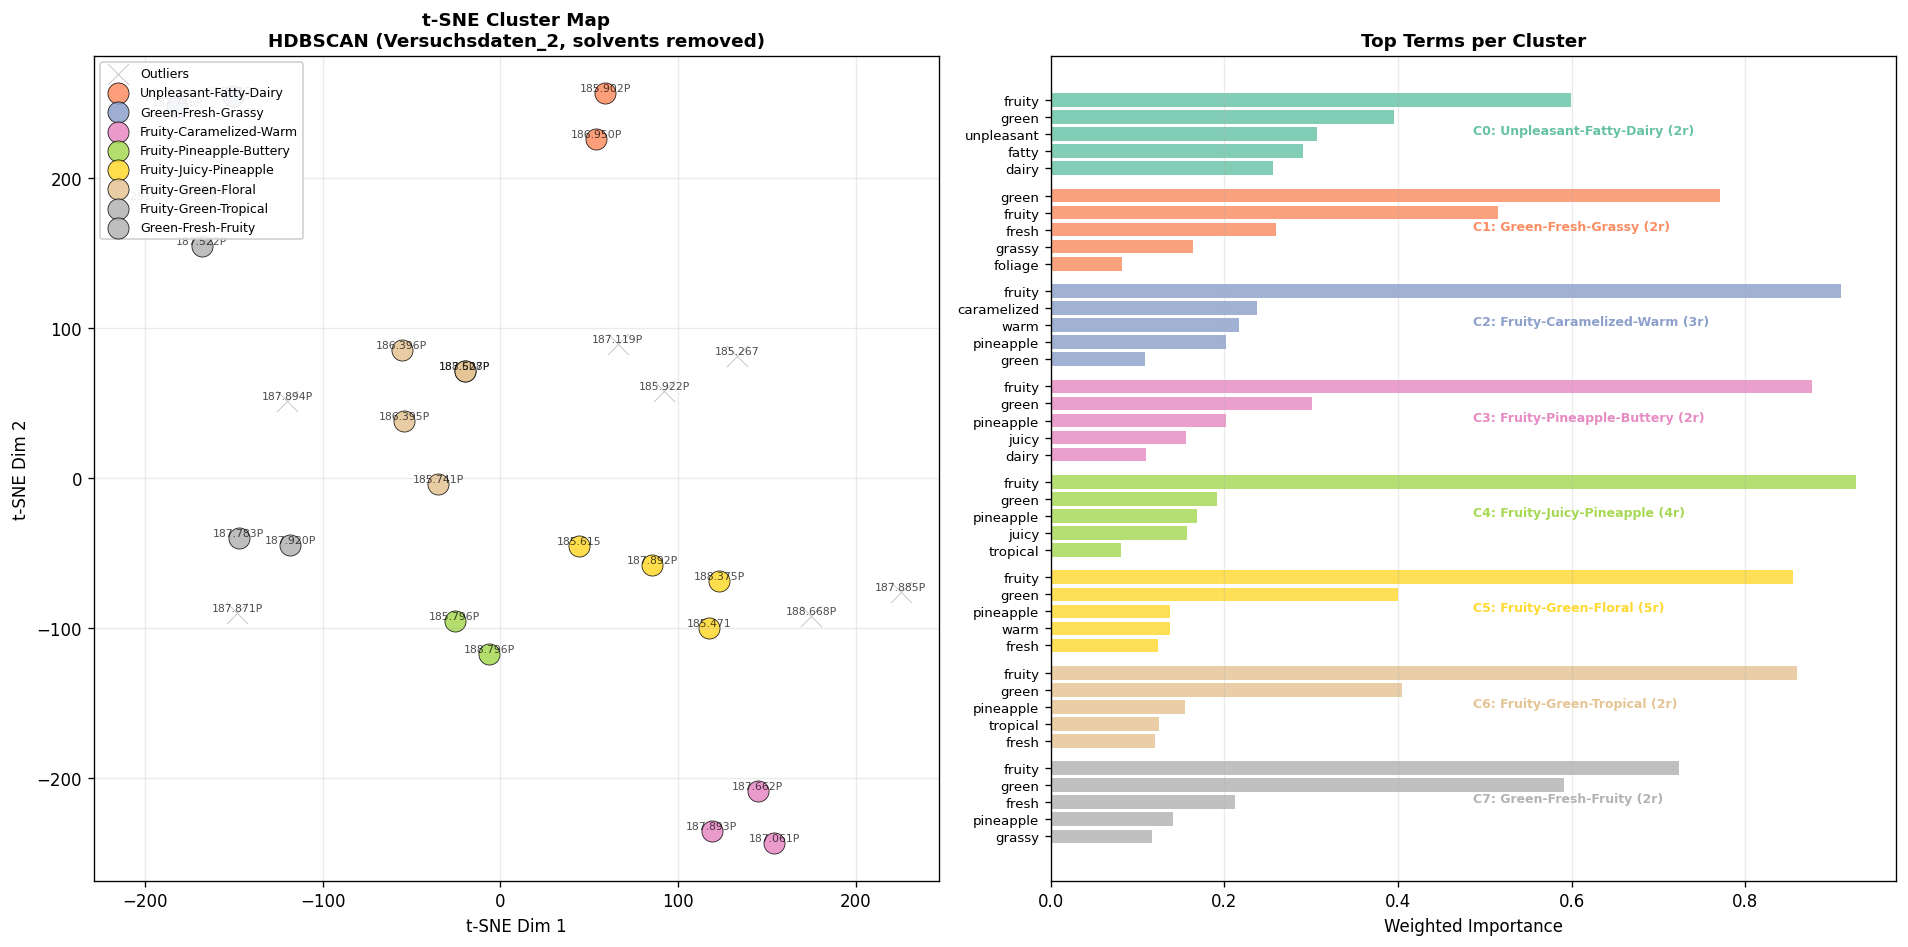

In [17]:
# t-SNE scatter + top terms
hdbscan_coords = visualize_clusters(
    hdbscan_labels, hdbscan_names, hdbscan_details,
    title="HDBSCAN (Versuchsdaten_2, solvents removed)",
    save_path=f"{OUTPUT_DIR}/v2_cluster_hdbscan.png")


Saved → ../outputs/v2_cluster_hdbscan_profiles.png


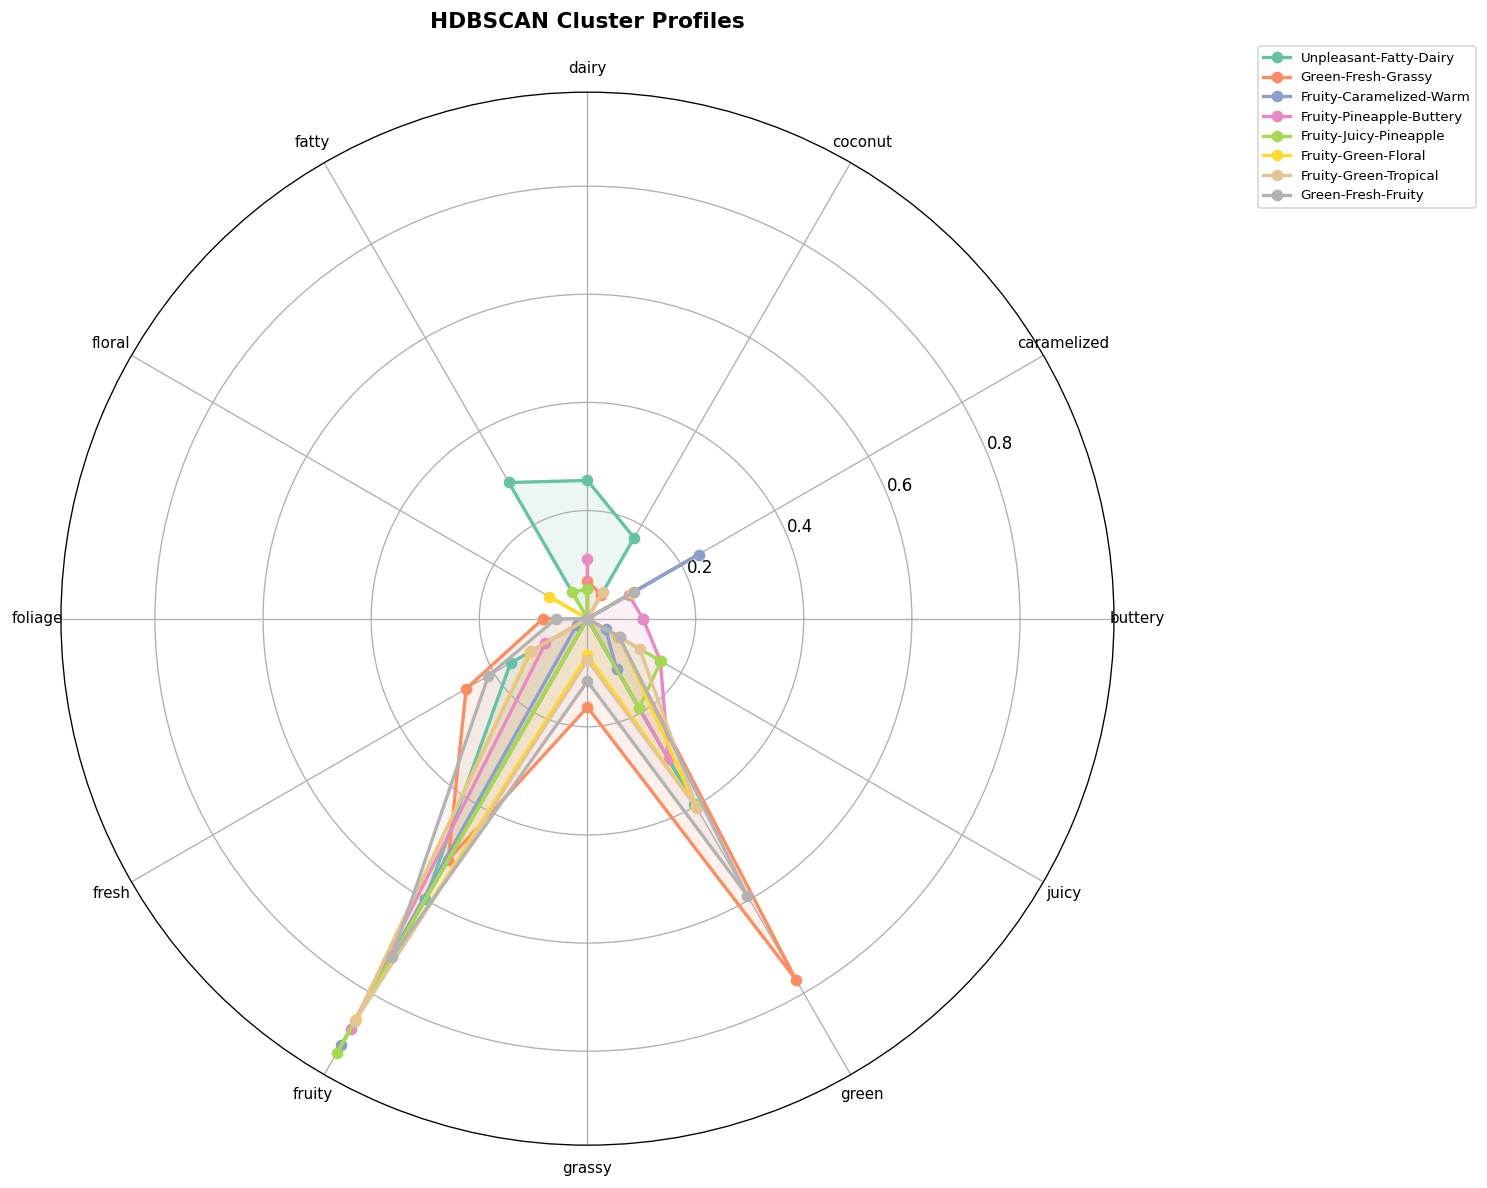

In [18]:
# Radar chart
visualize_radar(
    hdbscan_details, hdbscan_names,
    title="HDBSCAN Cluster Profiles",
    save_path=f"{OUTPUT_DIR}/v2_cluster_hdbscan_profiles.png")


In [19]:
print_summary(hdbscan_details)



────────────────────────────────────────────────
CLUSTER -1: Outliers  (8 recipes)
────────────────────────────────────────────────
  • 187.894P
  • 187.885P
  • 187.871P
  • 185.267
  • 187.119P
  • 185.922P
  • 186.293P
  • 188.668P
  Top profile:
    fruity               ████████████████████████████████ (0.822)
    green                ██████████ (0.264)
    dairy                █████ (0.125)
    warm                 ████ (0.122)
    pineapple            ████ (0.105)
    juicy                ███ (0.085)

────────────────────────────────────────────────
CLUSTER 0: Unpleasant-Fatty-Dairy  (2 recipes)
────────────────────────────────────────────────
  • 185.902P
  • 186.950P
  Top profile:
    fruity               ███████████████████████ (0.599)
    green                ███████████████ (0.396)
    unpleasant           ████████████ (0.306)
    fatty                ███████████ (0.291)
    dairy                ██████████ (0.256)
    sour                 ████████ (0.218)

────────────────

---
# Method 2: Agglomerative Clustering

Ward-linkage hierarchical clustering with automatic k selection via silhouette score.
All recipes guaranteed to be assigned (no outliers).


In [20]:
# Find optimal k
k_range = (3, 12)
agg_scores = []
for k in range(k_range[0], min(k_range[1]+1, len(recipes))):
    ac = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    lbl = ac.fit_predict(recipe_vectors)
    s = silhouette_score(recipe_vectors, lbl)
    agg_scores.append((k, s))

best_k_agg = max(agg_scores, key=lambda x: x[1])[0]
print("Silhouette scores by k:")
for k, s in agg_scores:
    marker = "  ← selected" if k == best_k_agg else ""
    print(f"  k={k:2d}: {s:.4f}{marker}")


Silhouette scores by k:
  k= 3: 0.3521
  k= 4: 0.3743  ← selected
  k= 5: 0.2427
  k= 6: 0.2909
  k= 7: 0.2964
  k= 8: 0.3073
  k= 9: 0.3082
  k=10: 0.3044
  k=11: 0.3380
  k=12: 0.3503


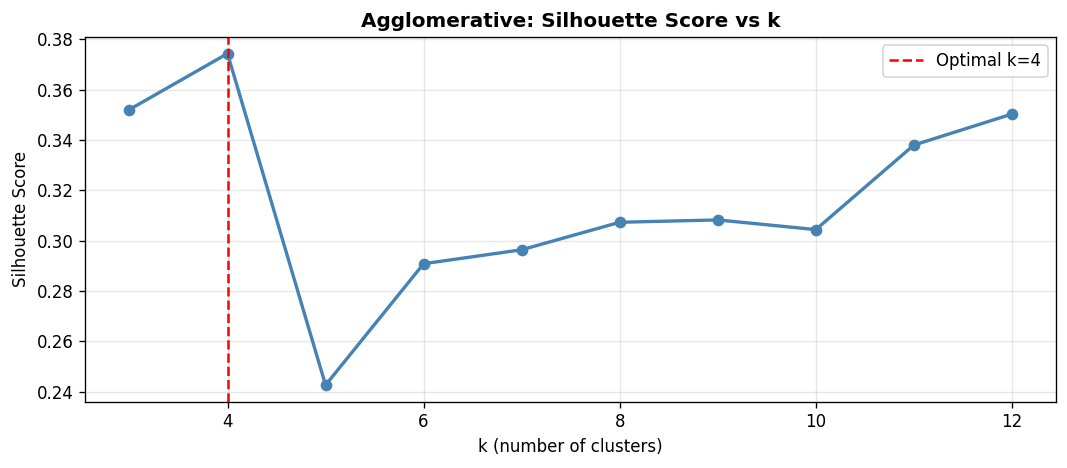

In [21]:
# Silhouette score plot
fig, ax = plt.subplots(figsize=(9, 4))
ks, ss = zip(*agg_scores)
ax.plot(ks, ss, 'o-', color='steelblue', lw=2)
ax.axvline(best_k_agg, color='red', linestyle='--', label=f'Optimal k={best_k_agg}')
ax.set_xlabel('k (number of clusters)'); ax.set_ylabel('Silhouette Score')
ax.set_title('Agglomerative: Silhouette Score vs k', fontweight='bold')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [22]:
# Run with optimal k
ac = AgglomerativeClustering(n_clusters=best_k_agg, metric='euclidean', linkage='ward')
agg_labels = ac.fit_predict(recipe_vectors)

print(f"Agglomerative (k={best_k_agg}) → {best_k_agg} clusters, 0 outliers")
for l in sorted(set(agg_labels)):
    count = list(agg_labels).count(l)
    singleton = "  (singleton)" if count == 1 else ""
    print(f"  Cluster {l}: {count} recipes{singleton}")


Agglomerative (k=4) → 4 clusters, 0 outliers
  Cluster 0: 22 recipes
  Cluster 1: 5 recipes
  Cluster 2: 1 recipes  (singleton)
  Cluster 3: 2 recipes


In [23]:
agg_names   = generate_cluster_names(agg_labels)
agg_details = get_details(agg_labels, agg_names)

print("\nCluster names:")
for l, name in sorted(agg_names.items()):
    print(f"  {l:3d}  {name}  ({list(agg_labels).count(l)} recipes)")



Cluster names:
    0  Fruity-Pineapple-Juicy  (22 recipes)
    1  Green-Fresh-Grassy  (5 recipes)
    2  Powerful-Dairy-Cheesy  (1 recipes)
    3  Unpleasant-Fatty-Dairy  (2 recipes)


Saved → ../outputs/v2_cluster_agglomerative.png


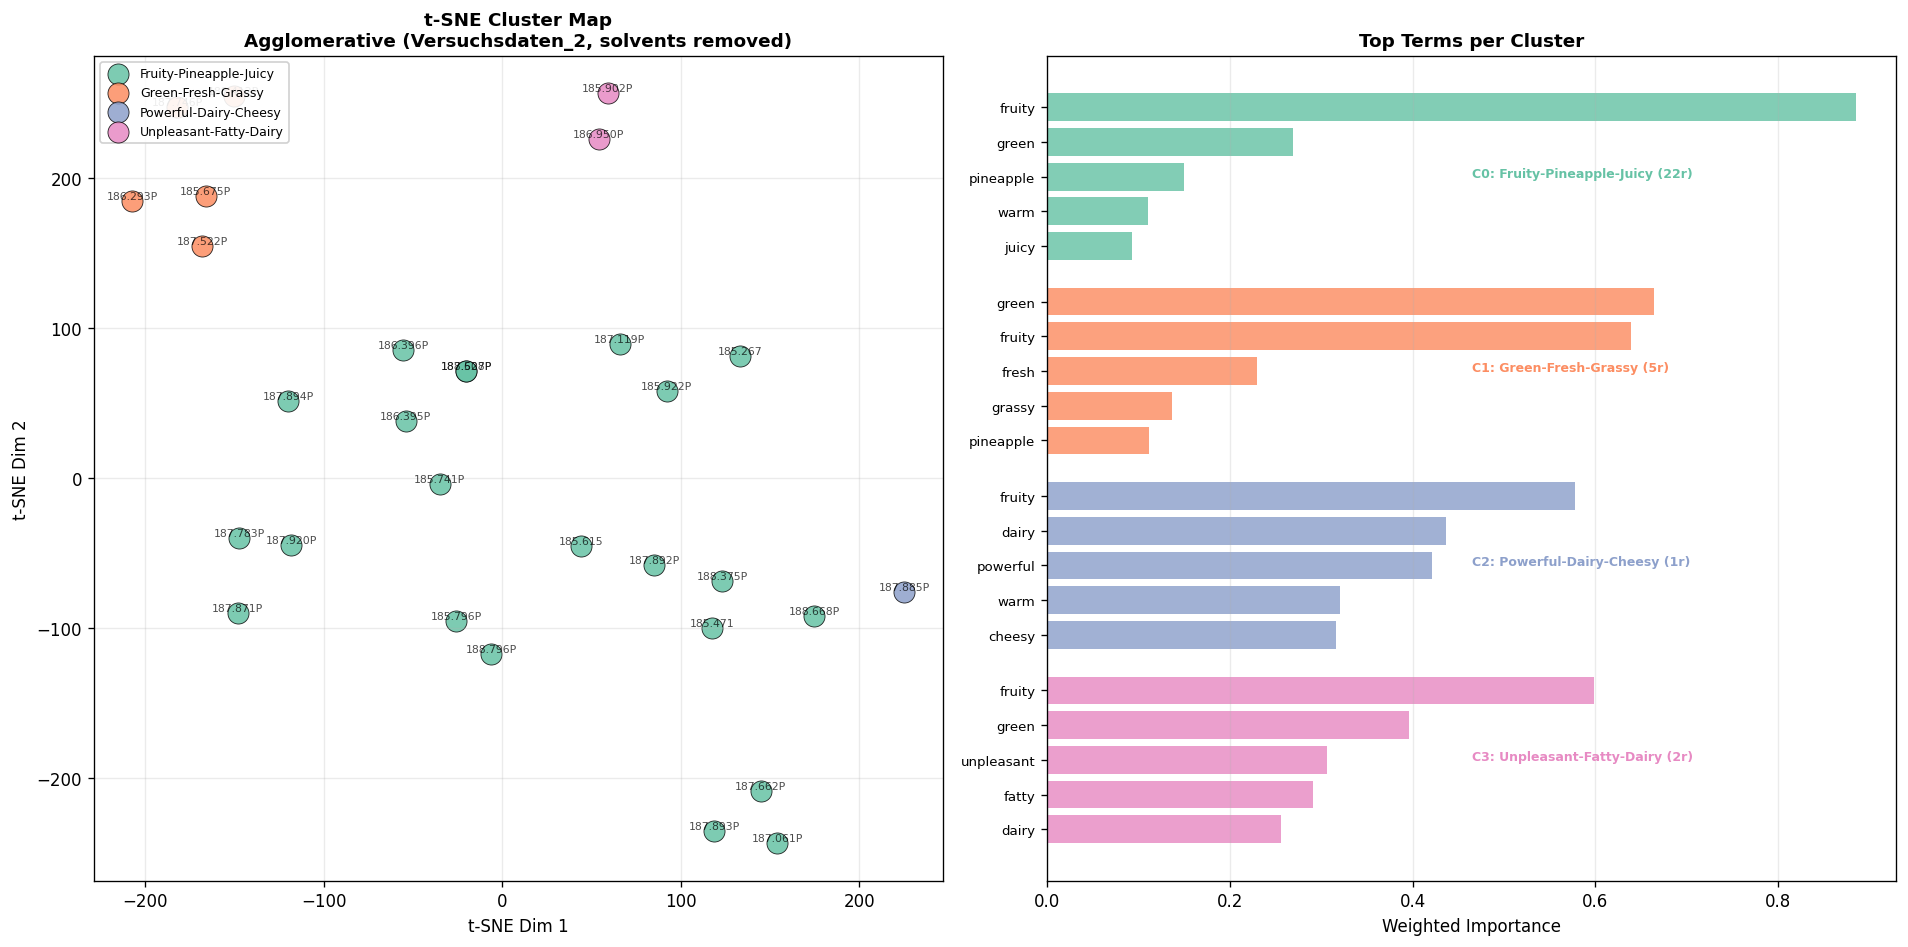

In [24]:
agg_coords = visualize_clusters(
    agg_labels, agg_names, agg_details,
    title="Agglomerative (Versuchsdaten_2, solvents removed)",
    save_path=f"{OUTPUT_DIR}/v2_cluster_agglomerative.png")


Saved → ../outputs/v2_cluster_agglomerative_profiles.png


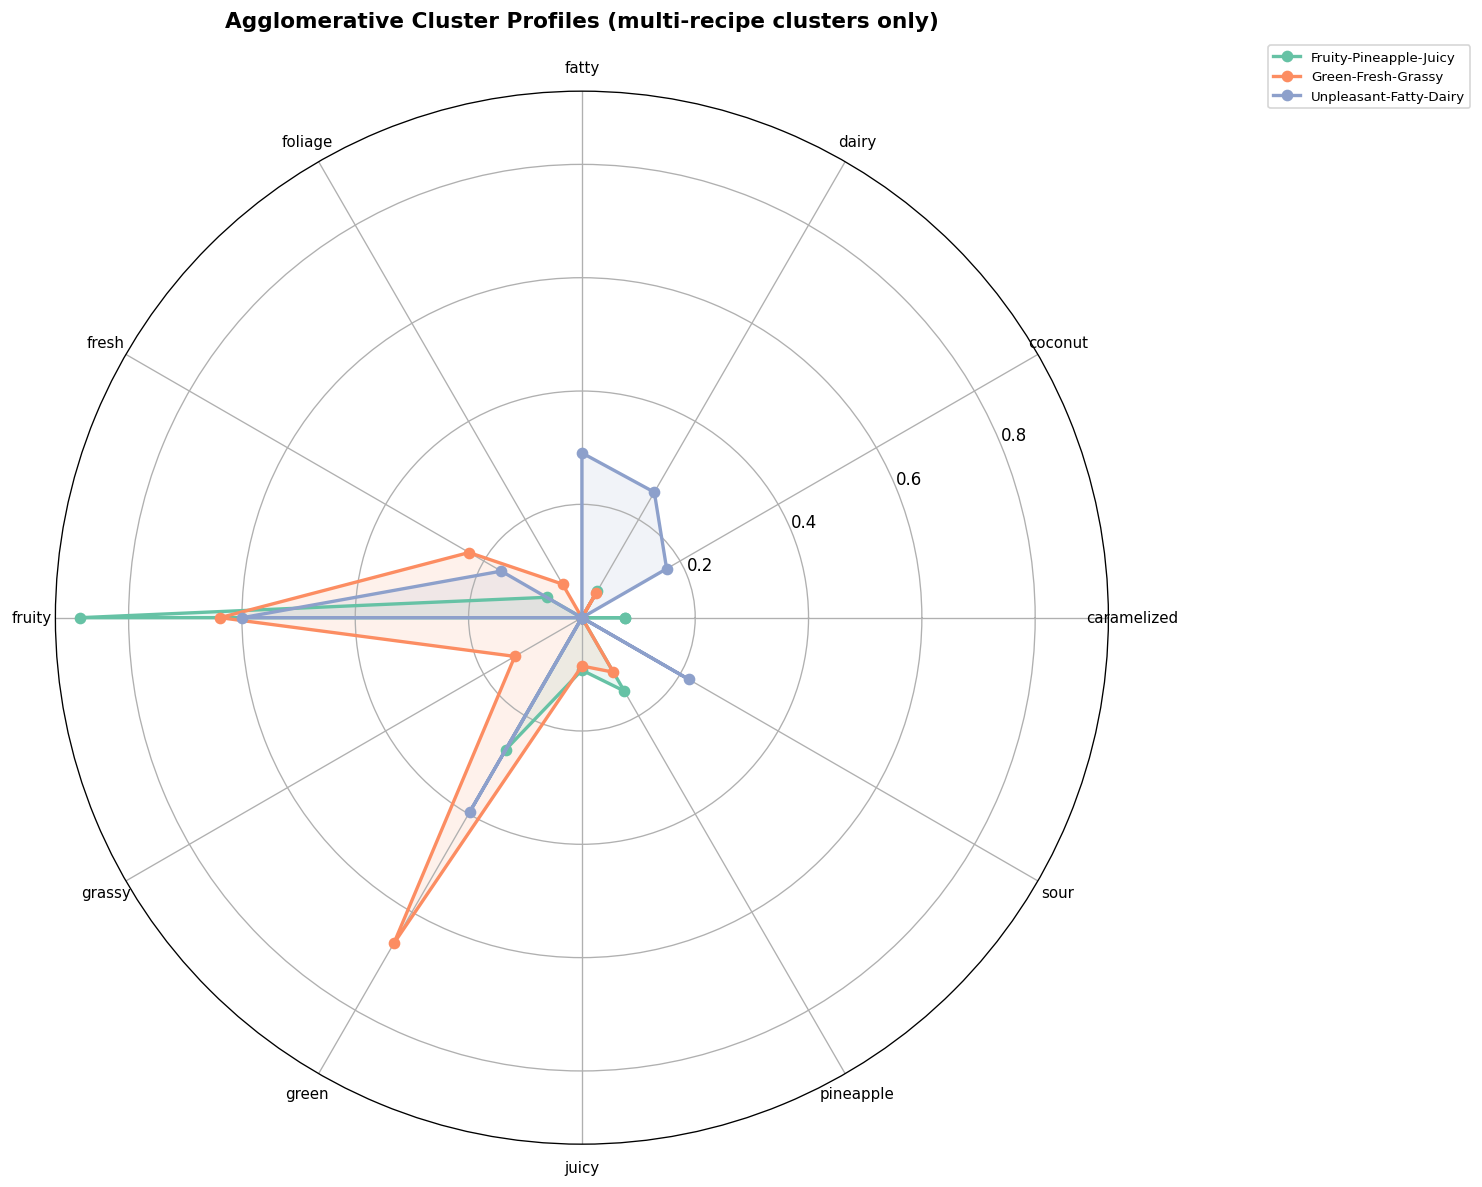

In [25]:
# Radar (excluding singletons for readability)
agg_details_multi = {l: v for l, v in agg_details.items() if v['size'] > 1}
visualize_radar(
    agg_details_multi, agg_names,
    title="Agglomerative Cluster Profiles (multi-recipe clusters only)",
    save_path=f"{OUTPUT_DIR}/v2_cluster_agglomerative_profiles.png")


In [26]:
print_summary(agg_details)



────────────────────────────────────────────────
CLUSTER 0: Fruity-Pineapple-Juicy  (22 recipes)
────────────────────────────────────────────────
  • 187.893P
  • 185.615
  • 187.061P
  • 187.783P
  • 187.892P
  • 187.894P
  • 188.375P
  • 185.796P
  • 188.796P
  • 187.871P
  • 185.267
  • 185.471
  • 187.119P
  • 185.741P
  • 186.395P
  • 186.396P
  • 187.507P
  • 188.628P
  • 185.922P
  • 188.668P
  • 187.920P
  • 187.662P
  Top profile:
    fruity               ███████████████████████████████████ (0.885)
    green                ██████████ (0.269)
    pineapple            █████ (0.150)
    warm                 ████ (0.110)
    juicy                ███ (0.093)
    caramelized          ███ (0.076)

────────────────────────────────────────────────
CLUSTER 1: Green-Fresh-Grassy  (5 recipes)
────────────────────────────────────────────────
  • 187.746P
  • 188.412P
  • 186.293P
  • 185.675P
  • 187.522P
  Top profile:
    green                ██████████████████████████ (0.664)
    fruit

---
# Method 3: FAISS Vector Database

FAISS k-means with automatic k selection. Provides similarity search for recipe creation.


In [27]:
if not FAISS_AVAILABLE:
    print("FAISS not installed – skipping Method 3")
    print("Install with: pip install faiss-cpu")
else:
    vectors_f32 = np.ascontiguousarray(recipe_vectors.astype('float32'))
    n_v, d = vectors_f32.shape

    faiss_index = faiss.IndexFlatL2(d)
    faiss_index.add(vectors_f32)
    print(f"FAISS index: {faiss_index.ntotal} vectors, {d} dimensions")


FAISS index: 30 vectors, 161 dimensions


In [28]:
if FAISS_AVAILABLE:
    k_range_f = (3, 12)
    faiss_scores = []
    best_k_faiss, best_score_faiss = k_range_f[0], -1
    best_faiss_labels, best_centroids = None, None

    for k in range(k_range_f[0], min(k_range_f[1]+1, n_v)):
        km = faiss.Kmeans(d, k, niter=50, verbose=False, seed=42)
        km.train(vectors_f32)
        _, lbl = km.index.search(vectors_f32, 1)
        lbl = lbl.flatten()
        if len(set(lbl)) > 1:
            s = silhouette_score(vectors_f32, lbl)
            faiss_scores.append((k, s))
            if s > best_score_faiss:
                best_score_faiss = s
                best_k_faiss = k
                best_faiss_labels = lbl.copy()
                best_centroids = km.centroids.copy()

    print("FAISS silhouette scores by k:")
    for k, s in faiss_scores:
        marker = "  ← selected" if k == best_k_faiss else ""
        print(f"  k={k:2d}: {s:.4f}{marker}")


FAISS silhouette scores by k:
  k= 3: 0.1864
  k= 4: 0.3079  ← selected
  k= 5: 0.1878
  k= 6: 0.2060
  k= 7: 0.1747
  k= 8: 0.2035
  k= 9: 0.2721
  k=10: 0.2693
  k=11: 0.2884
  k=12: 0.2454


WARNING clustering 30 points to 3 centroids: please provide at least 117 training points
WARNING clustering 30 points to 4 centroids: please provide at least 156 training points
WARNING clustering 30 points to 5 centroids: please provide at least 195 training points
WARNING clustering 30 points to 6 centroids: please provide at least 234 training points
WARNING clustering 30 points to 7 centroids: please provide at least 273 training points
WARNING clustering 30 points to 8 centroids: please provide at least 312 training points
WARNING clustering 30 points to 9 centroids: please provide at least 351 training points
WARNING clustering 30 points to 10 centroids: please provide at least 390 training points
WARNING clustering 30 points to 11 centroids: please provide at least 429 training points
WARNING clustering 30 points to 12 centroids: please provide at least 468 training points


In [29]:
if FAISS_AVAILABLE:
    faiss_labels = best_faiss_labels
    faiss_names   = generate_cluster_names(faiss_labels)
    faiss_details = get_details(faiss_labels, faiss_names)

    print(f"FAISS (k={best_k_faiss}) → {best_k_faiss} clusters, 0 outliers")
    for l in sorted(set(faiss_labels)):
        print(f"  Cluster {l}: {list(faiss_labels).count(l)} recipes  |  {faiss_names[l]}")


FAISS (k=4) → 4 clusters, 0 outliers
  Cluster 0: 5 recipes  |  Green-Fresh-Grassy
  Cluster 1: 2 recipes  |  Unpleasant-Fatty-Dairy
  Cluster 2: 18 recipes  |  Fruity-Green-Pineapple
  Cluster 3: 5 recipes  |  Fruity-Warm-Caramelized


Saved → ../outputs/v2_cluster_faiss.png


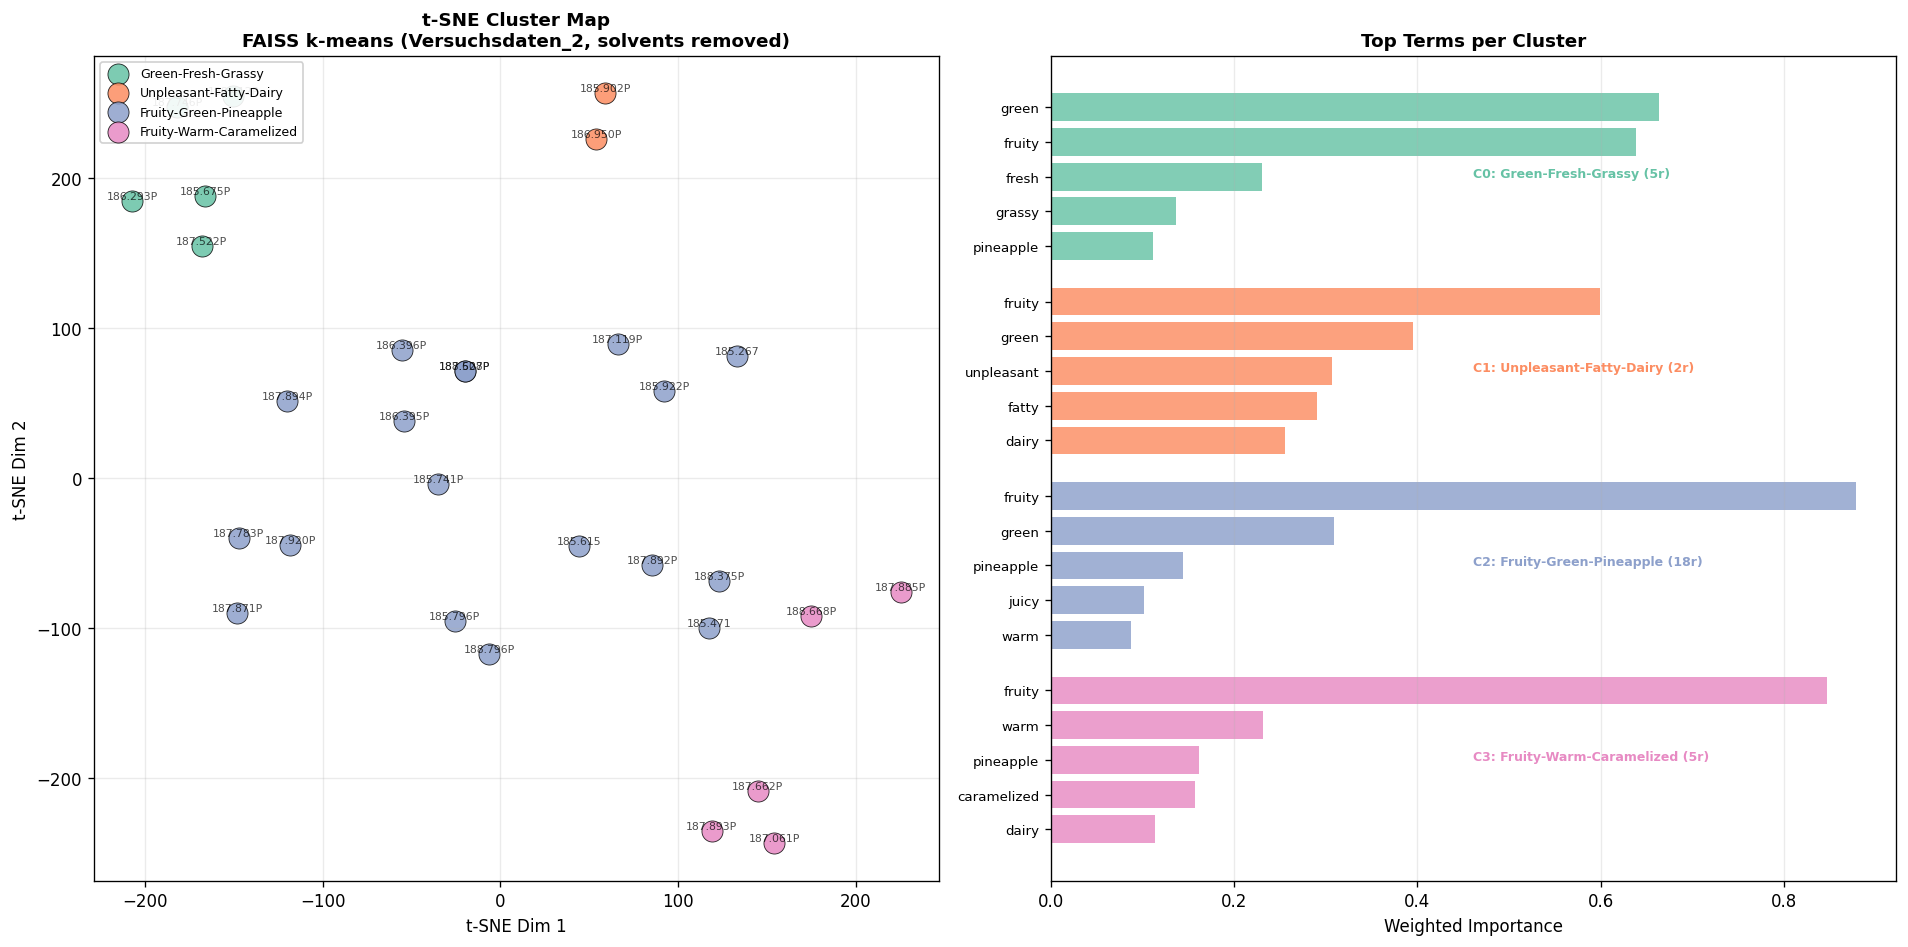

In [30]:
if FAISS_AVAILABLE:
    faiss_coords = visualize_clusters(
        faiss_labels, faiss_names, faiss_details,
        title="FAISS k-means (Versuchsdaten_2, solvents removed)",
        save_path=f"{OUTPUT_DIR}/v2_cluster_faiss.png")


Saved → ../outputs/v2_cluster_faiss_profiles.png


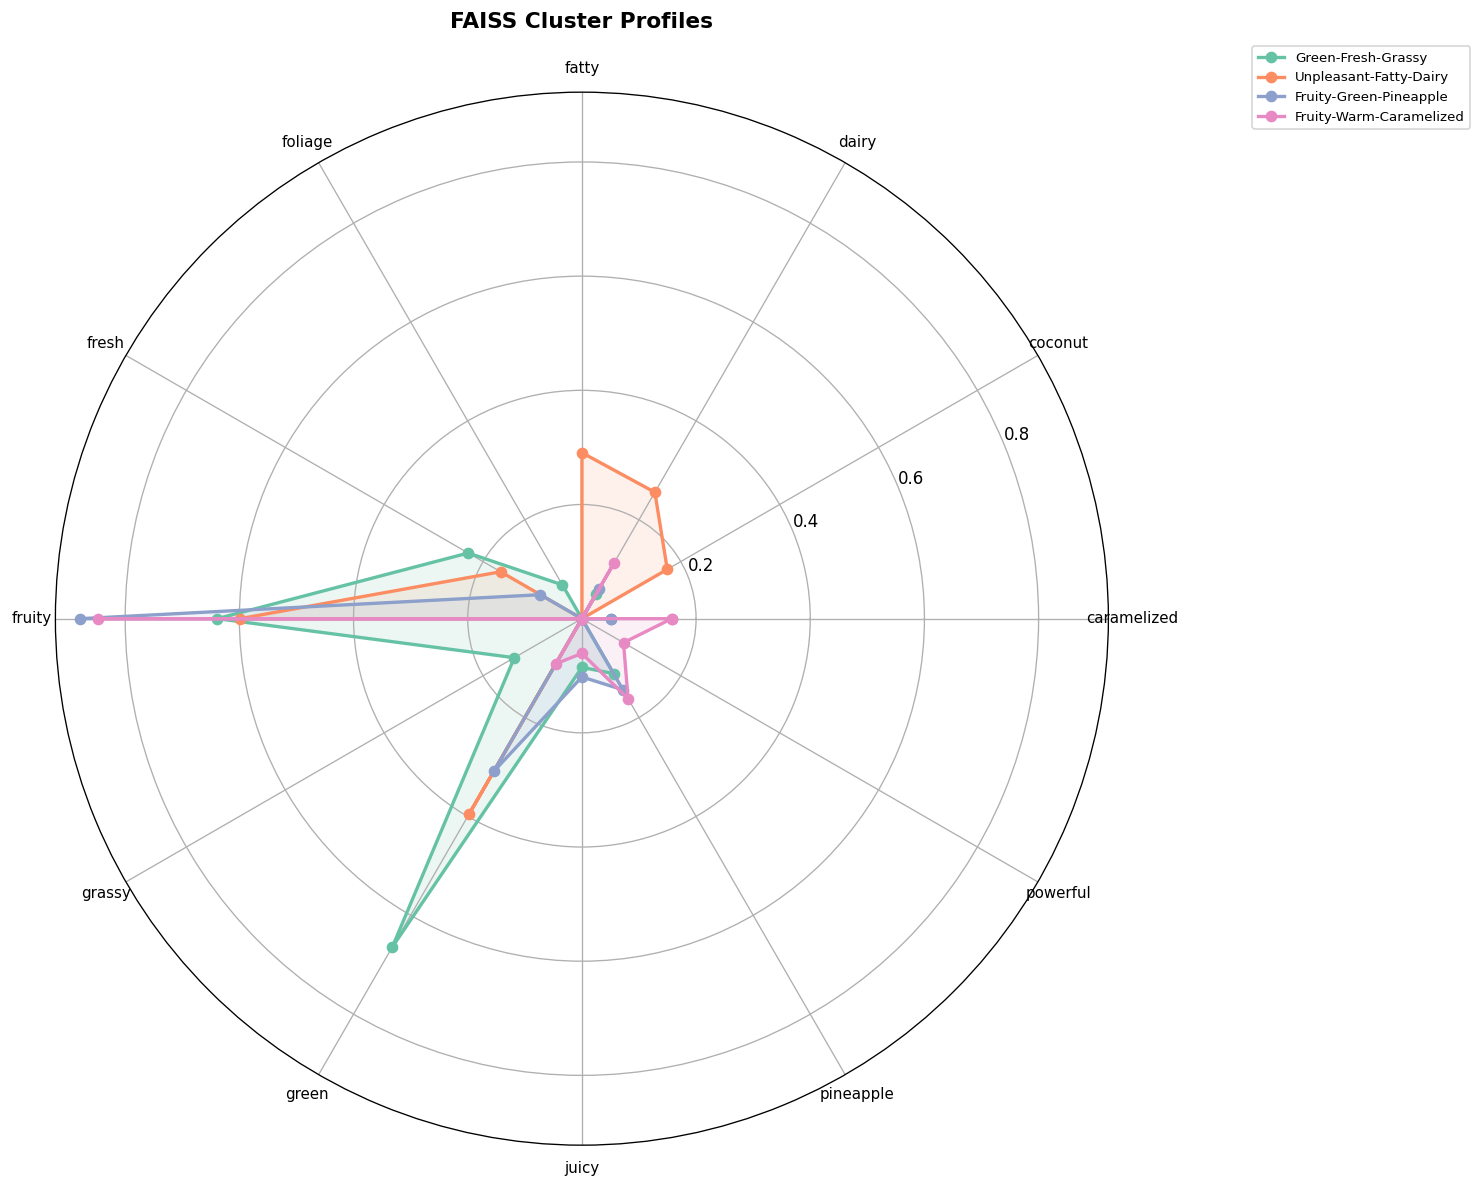

In [31]:
if FAISS_AVAILABLE:
    visualize_radar(
        faiss_details, faiss_names,
        title="FAISS Cluster Profiles",
        save_path=f"{OUTPUT_DIR}/v2_cluster_faiss_profiles.png")


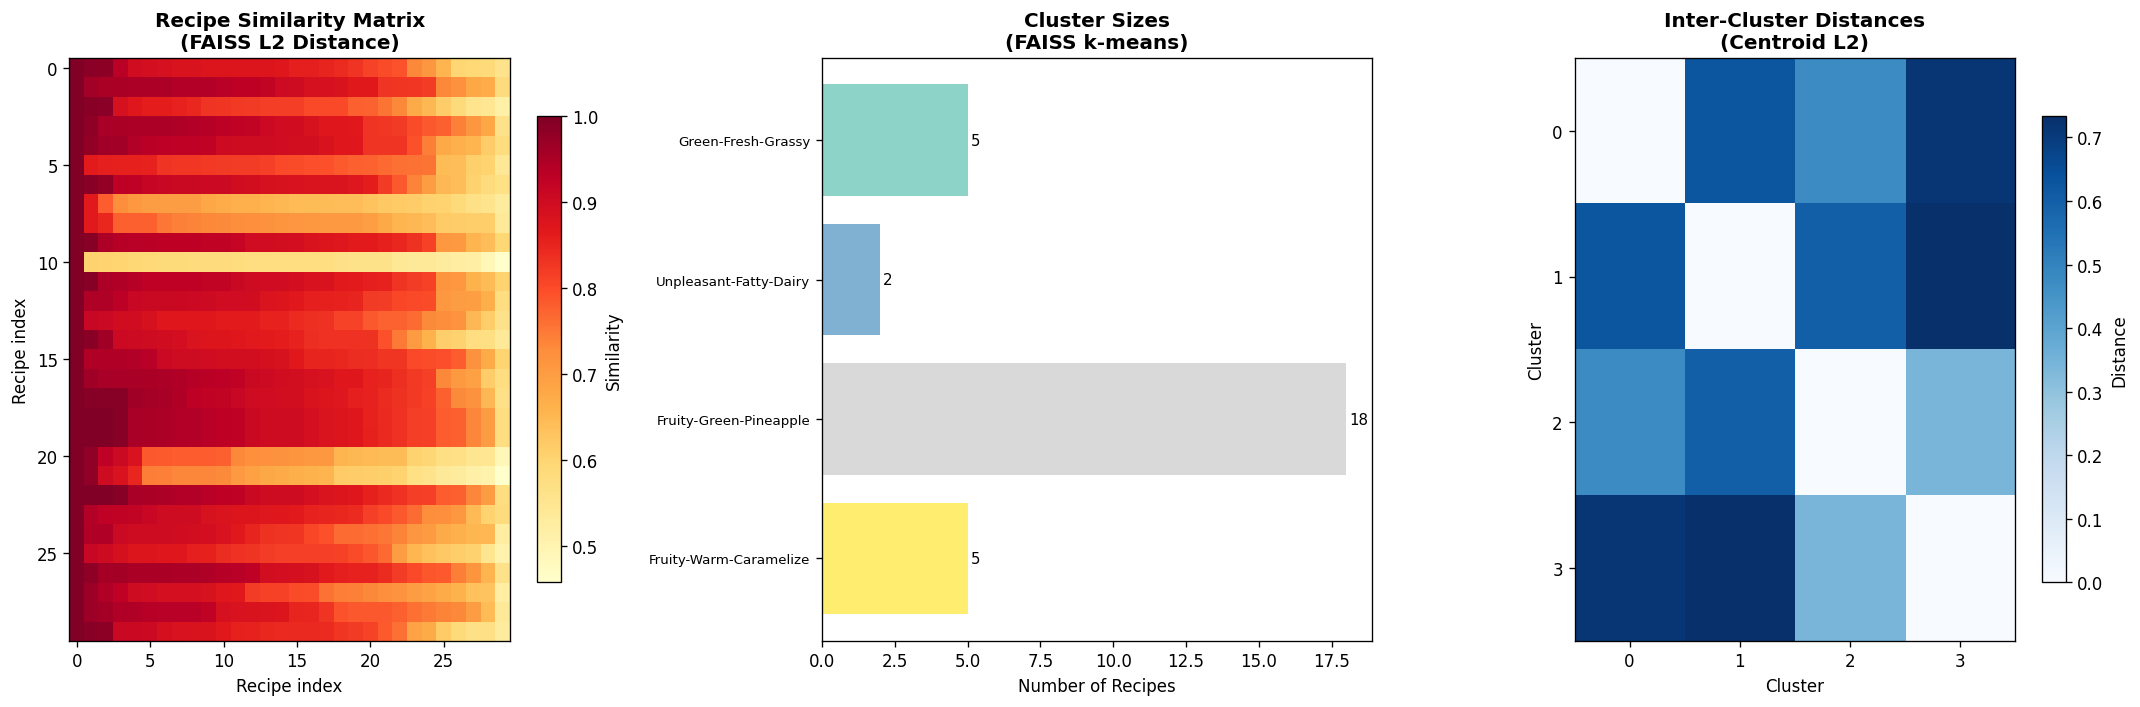

Saved → v2_cluster_faiss_similarity.png


In [32]:
if FAISS_AVAILABLE:
    # Similarity matrix + cluster sizes + centroid distances
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Similarity heatmap
    dists, _ = faiss_index.search(vectors_f32, n_v)
    similarity = 1 / (1 + dists)
    im1 = axes[0].imshow(similarity, cmap='YlOrRd', aspect='auto')
    axes[0].set_title('Recipe Similarity Matrix\n(FAISS L2 Distance)', fontweight='bold')
    axes[0].set_xlabel('Recipe index'); axes[0].set_ylabel('Recipe index')
    plt.colorbar(im1, ax=axes[0], shrink=0.8, label='Similarity')

    # 2. Cluster sizes
    ul = sorted(set(faiss_labels))
    sizes_f = [list(faiss_labels).count(l) for l in ul]
    names_f = [faiss_names.get(l, f'C{l}')[:22] for l in ul]
    clrs = plt.cm.Set3(np.linspace(0, 1, len(ul)))
    bars = axes[1].barh(range(len(ul)), sizes_f, color=clrs)
    axes[1].set_yticks(range(len(ul))); axes[1].set_yticklabels(names_f, fontsize=8)
    axes[1].set_xlabel('Number of Recipes')
    axes[1].set_title('Cluster Sizes\n(FAISS k-means)', fontweight='bold')
    axes[1].invert_yaxis()
    for bar, sz in zip(bars, sizes_f):
        axes[1].text(bar.get_width()+0.1, bar.get_y()+bar.get_height()/2,
                     str(sz), va='center', fontsize=9)

    # 3. Centroid distances
    k_c = len(best_centroids)
    cdist = np.array([[np.linalg.norm(best_centroids[i]-best_centroids[j])
                       for j in range(k_c)] for i in range(k_c)])
    im3 = axes[2].imshow(cdist, cmap='Blues', aspect='auto')
    axes[2].set_title('Inter-Cluster Distances\n(Centroid L2)', fontweight='bold')
    axes[2].set_xlabel('Cluster'); axes[2].set_ylabel('Cluster')
    axes[2].set_xticks(range(k_c)); axes[2].set_yticks(range(k_c))
    plt.colorbar(im3, ax=axes[2], shrink=0.8, label='Distance')

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/v2_cluster_faiss_similarity.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved → v2_cluster_faiss_similarity.png")


In [33]:
if FAISS_AVAILABLE:
    print_summary(faiss_details)



────────────────────────────────────────────────
CLUSTER 0: Green-Fresh-Grassy  (5 recipes)
────────────────────────────────────────────────
  • 187.746P
  • 188.412P
  • 186.293P
  • 185.675P
  • 187.522P
  Top profile:
    green                ██████████████████████████ (0.664)
    fruity               █████████████████████████ (0.639)
    fresh                █████████ (0.230)
    grassy               █████ (0.137)
    pineapple            ████ (0.111)
    juicy                ███ (0.085)

────────────────────────────────────────────────
CLUSTER 1: Unpleasant-Fatty-Dairy  (2 recipes)
────────────────────────────────────────────────
  • 185.902P
  • 186.950P
  Top profile:
    fruity               ███████████████████████ (0.599)
    green                ███████████████ (0.396)
    unpleasant           ████████████ (0.306)
    fatty                ███████████ (0.291)
    dairy                ██████████ (0.256)
    sour                 ████████ (0.218)

───────────────────────────────

## FAISS Similarity Search Demo

In [34]:
if FAISS_AVAILABLE:
    def find_similar(recipe_idx, top_k=5):
        q = recipe_vectors[recipe_idx:recipe_idx+1].astype('float32')
        d, idx = faiss_index.search(q, top_k+1)
        return [(recipes[i], float(di)) for di, i in zip(d[0], idx[0]) if i != recipe_idx][:top_k]

    for i in [0, len(recipes)//2, len(recipes)-1]:
        print(f"\nRecipes similar to '{recipes[i]}':")
        for r, dist in find_similar(i, 3):
            print(f"  • {r}  (L2={dist:.4f})")



Recipes similar to '187.893P':
  • 187.061P  (L2=0.0137)
  • 187.662P  (L2=0.0156)
  • 185.741P  (L2=0.0710)

Recipes similar to '187.119P':
  • 186.396P  (L2=0.0604)
  • 187.507P  (L2=0.0604)
  • 188.628P  (L2=0.0604)

Recipes similar to '187.662P':
  • 187.061P  (L2=0.0119)
  • 187.893P  (L2=0.0156)
  • 188.375P  (L2=0.0980)


---
# Comparison of All Three Methods


In [35]:
# Build comparison table
rows = []
# HDBSCAN
n_c_h = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
rows.append({'Method':'HDBSCAN', 'Clusters':n_c_h,
             'Outliers':list(hdbscan_labels).count(-1),
             'Singletons':sum(1 for l in set(hdbscan_labels) if l!=-1 and list(hdbscan_labels).count(l)==1),
             'Similarity Search':'No'})
# Agglomerative
rows.append({'Method':'Agglomerative', 'Clusters':best_k_agg, 'Outliers':0,
             'Singletons':sum(1 for l in set(agg_labels) if list(agg_labels).count(l)==1),
             'Similarity Search':'No'})
# FAISS
if FAISS_AVAILABLE:
    rows.append({'Method':'FAISS', 'Clusters':best_k_faiss, 'Outliers':0,
                 'Singletons':sum(1 for l in set(faiss_labels) if list(faiss_labels).count(l)==1),
                 'Similarity Search':'Yes'})

comp_df = pd.DataFrame(rows).set_index('Method')
print(comp_df.to_string())
comp_df


               Clusters  Outliers  Singletons Similarity Search
Method                                                         
HDBSCAN               8         8           0                No
Agglomerative         4         0           1                No
FAISS                 4         0           0               Yes


,Clusters,Outliers,Singletons,Similarity Search
Method,,,,
HDBSCAN,8,8,0,No
Agglomerative,4,0,1,No
FAISS,4,0,0,Yes


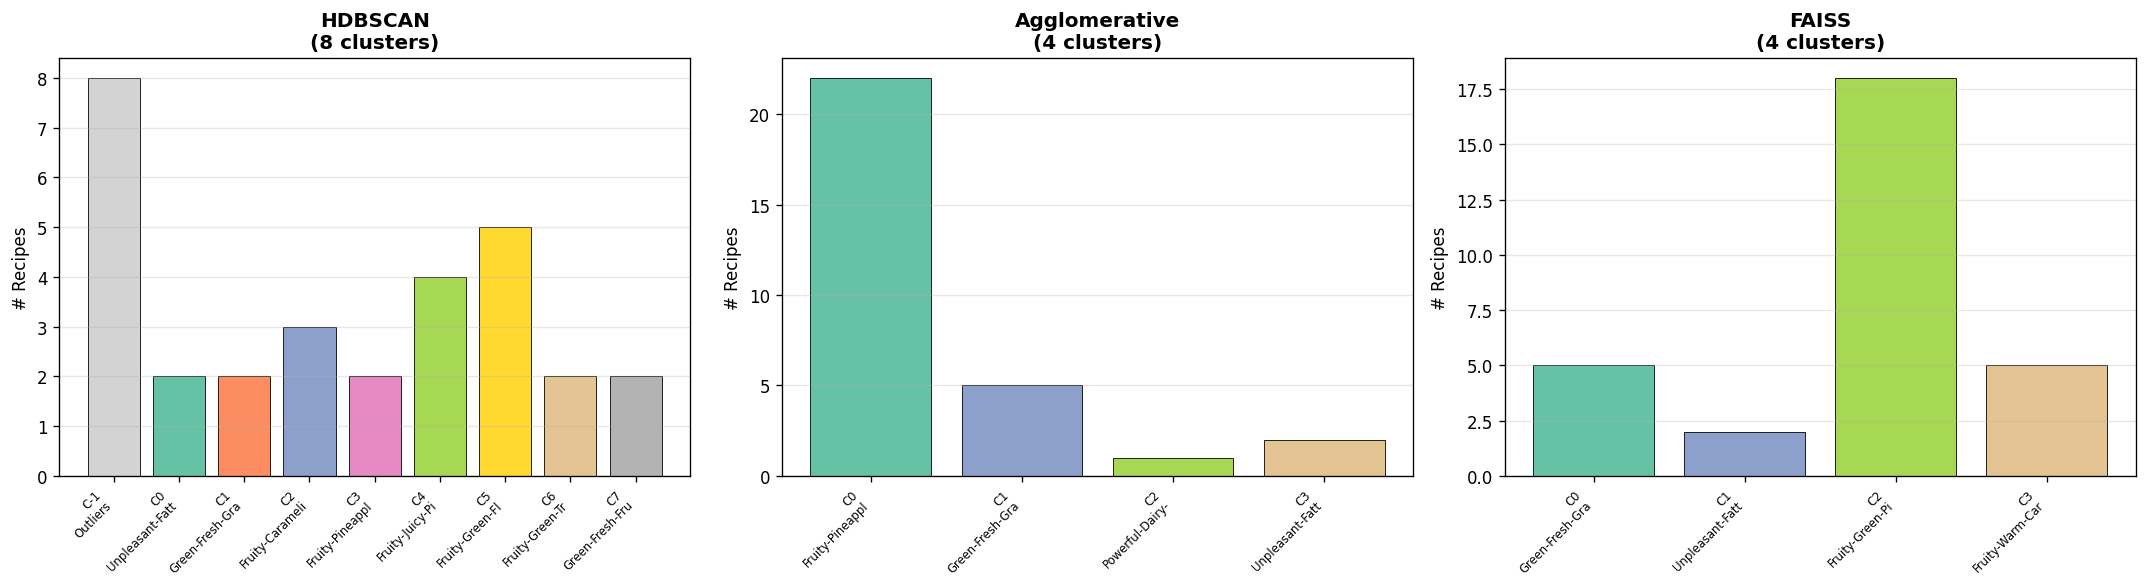

Saved → v2_comparison.png


In [36]:
# Visual comparison of cluster distributions
n_methods = 2 + (1 if FAISS_AVAILABLE else 0)
fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))

method_data = [('HDBSCAN', hdbscan_labels, hdbscan_names),
               ('Agglomerative', agg_labels, agg_names)]
if FAISS_AVAILABLE:
    method_data.append(('FAISS', faiss_labels, faiss_names))

for ax, (name, labels, names) in zip(axes, method_data):
    unique = sorted(set(labels))
    sizes  = [list(labels).count(l) for l in unique]
    lbls   = [f"C{l}\n{names.get(l,'')[:15]}" for l in unique]
    colors = ['lightgray' if l==-1 else
              plt.cm.Set2(i/max(len(unique),1)) for i, l in enumerate(unique)]
    ax.bar(range(len(unique)), sizes, color=colors, edgecolor='black', lw=0.5)
    ax.set_xticks(range(len(unique)))
    ax.set_xticklabels(lbls, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel('# Recipes')
    ax.set_title(f'{name}\n({len(set(l for l in labels if l!=-1))} clusters)', fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/v2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved → v2_comparison.png")


---
# Summary

## Method guide

| Method | Best for |
|--------|----------|
| **HDBSCAN** | Identifying outlier/unique recipes; exploratory analysis |
| **Agglomerative** | Fine-grained categorisation; hierarchical relationships |
| **FAISS** | Recipe creation by cluster blending; similarity search |

## Feature engineering improvements over V1

| Factor | Role in vector |
|--------|---------------|
| Sensorik_1–4 | Positional weight captures prominence within ingredient |
| Odour Type 1–3 | Same positional logic; broader flavour-wheel categories |
| Totalmenge | Scales ingredient contribution by its recipe share |
| Threshold ppm | `1/Threshold` boosts highly-detectable substances |
| Ignore list | Solvents/carriers removed so clustering reflects aroma, not carrier |
